# UMAP for Supervised Dimension Reduction and Metric Learning

While UMAP can be used for standard unsupervised dimension reduction the algorithm offers significant flexibility allowing it to be extended to perform other tasks, including making use of categorical label information to do supervised dimension reduction, and even metric learning. We'll look at some examples of how to do that below.

First we will need to load some base libraries -- ``numpy``, obviously, but also ``mnist`` to read in the Fashion-MNIST data, and matplotlib and seaborn for plotting.

In [1]:
import numpy as np
from mnist import MNIST
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style='white', context='poster')

Our example dataset for this exploration will be the [Fashion-MNIST dataset from Zalando Research](https://github.com/zalandoresearch/fashion-mnist). It is desgined to be a drop-in replacement for the classic MNIST digits dataset, but uses images of fashion items (dresses, coats, shoes, bags, etc.) instead of handwritten digits. Since the images are more complex it provides a greater challenge than MNIST digits. We can load it in (after downloading the dataset) using the [mnist library](https://pypi.org/project/python-mnist/). We can then package up the train and test sets into one large dataset, normalise the values (to be in the range \[0,1\]), and set up labels for the 10 classes.

In [6]:
mndata = MNIST('fashion-mnist/data/fashion')
train, train_labels = mndata.load_training()
test, test_labels = mndata.load_testing()
data = np.array(np.vstack([train, test]), dtype=np.float64) / 255.0
target = np.hstack([train_labels, test_labels])
classes = [
    'T-shirt/top',
    'Trouser',
    'Pullover',
    'Dress',
    'Coat',
    'Sandal',
    'Shirt',
    'Sneaker',
    'Bag',
    'Ankle boot']

Next we'll load the ``umap`` library so we can do dimension reduction on this dataset.

In [7]:
import umap

## UMAP on Fashion MNIST

First we'll just do standard unsupervised dimension reduction using UMAP so we have a baseline of what the results look like for later comparison. This is simply a matter of instiantiating a UMAP object (in this case setting the ``n_neighbors`` parameter to be 5 -- we are interested mostly in very local information), then calling the ``fit_transform`` method with the data we wish to reduce. By default UMAP reduces to two dimensions, so we'll be able to view the results as a scatterplot.

In [8]:
%%time
embedding = umap.UMAP(n_neighbors=5).fit_transform(data)

CPU times: user 1min 45s, sys: 7.22 s, total: 1min 52s
Wall time: 1min 26s


That took a little time, but not all that long considering it is 70,000 data points in 784 dimensional space. We can simply plot the results as a scatterplot, colored by the class of the fashion item. We can use matplotlibs colorbar with suitable tick-labels to give us the color key.

Text(0.5,1,'Fashion MNIST Embedded via UMAP')

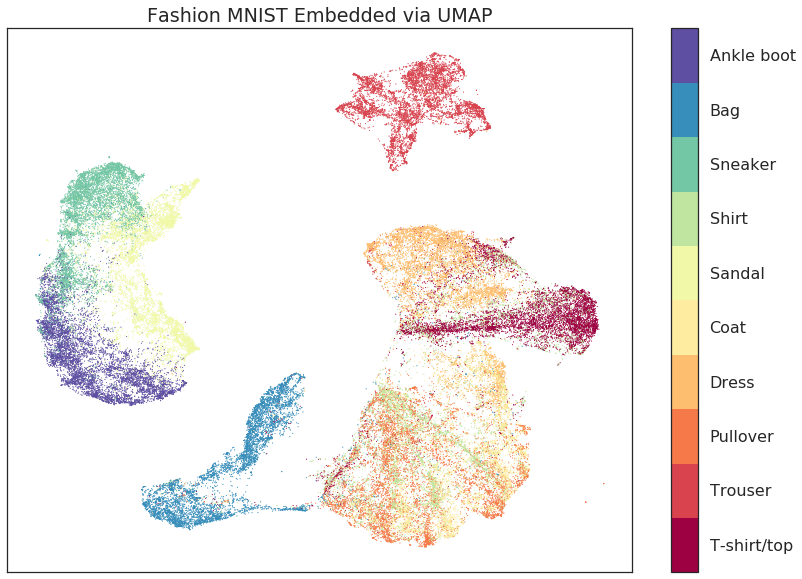

In [9]:
fig, ax = plt.subplots(1, figsize=(14, 10))
plt.scatter(*embedding.T, s=0.3, c=target, cmap='Spectral', alpha=1.0)
plt.setp(ax, xticks=[], yticks=[])
cbar = plt.colorbar(boundaries=np.arange(11)-0.5)
cbar.set_ticks(np.arange(10))
cbar.set_ticklabels(classes)
plt.title('Fashion MNIST Embedded via UMAP');

The result is fairly good. We successfully separated a number of the classes, and the global structure (separating pants and footwear from shirts, coats and dresses) is well preserved as well. Unlike results for MNIST digits, however, there were a number of classes that did not separate quite so cleanly. In particular T-shirts, shirts, dresses, pullovers, and coats are all a little mixed. At the very least the dresses are largely separated, and the T-shirts are mostly in one large clump, but they are not well distinguished from the others. Worse still are the coats, shirts, and pullovers (somewhat unsruprisingly as these can certainly look very similar) which all have significant overlap with one another. Ideally we would like much better class separation. Since we have the label information we can actually give that to UMAP to use!

## Using Labels to Separate Classes (Supervised UMAP)

How do we go about coercing UMAP to make use of target labels? If you are familiar with the sklearn API you'll know that the ``fit`` method takes a target parameter ``y`` that specifies supervised target information (for example when training a supervised classification model). We can simply pass the ``UMAP`` model that target data when fitting and it will make use of it to perform supervised dimension reduction!

In [10]:
%%time
embedding = umap.UMAP().fit_transform(data, y=target)

/opt/anaconda3/envs/umap_dev/lib/python3.6/site-packages/umap_learn-0.3.0-py3.6.egg/umap/spectral.py:187: UserWarning: Embedding 4 connected components using meta-embedding (experimental)


CPU times: user 3min 28s, sys: 9.17 s, total: 3min 37s
Wall time: 2min 45s


This took a little longer -- both because we are using a larger ``n_neighbors`` value (which is suggested when doing supervised dimension reduction; here we are using the default value of 15), and because we need to condition on the label data. As before we have reduced the data down to two dimensions so we can again visualize the data with a scatterplot, coloring by class.

Text(0.5,1,'Fashion MNIST Embedded via UMAP using Labels')

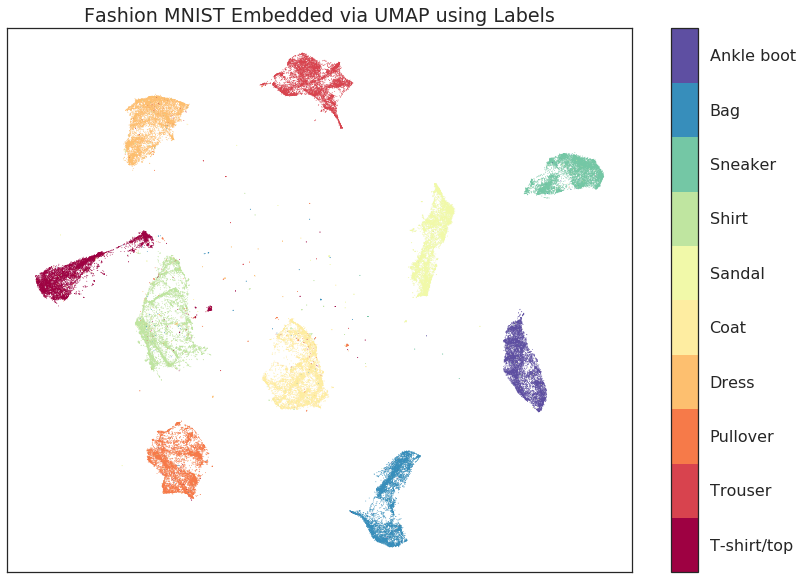

In [11]:
fig, ax = plt.subplots(1, figsize=(14, 10))
plt.scatter(*embedding.T, s=0.1, c=target, cmap='Spectral', alpha=1.0)
plt.setp(ax, xticks=[], yticks=[])
cbar = plt.colorbar(boundaries=np.arange(11)-0.5)
cbar.set_ticks(np.arange(10))
cbar.set_ticklabels(classes)
plt.title('Fashion MNIST Embedded via UMAP using Labels');

The result is a cleanly separated set of classes (and a little bit of stray noise -- points that were sufficiently different from their class as to not be grouped with the rest). Aside from the clear class separation however (which is expected -- we gave the algorithm all the class information), there are a couple of important points to note. The first point to note is that we have retained the internal structure of the individual classes. Both the shirts and pullovers still have the distinct banding pattern that was visible in the original unsupervised case; the pants, t-shirts and bags both retained their shape and internal structure; etc. The second point to note is that we have also retained the global structure. While the individual classes have been cleanly seprated from one another, the inter-relationships among the classes have been preserved: footwear classes are all near one another; trousers and bags are at opposite sides of the plot; and the arc of pullover, shirts, t-shirts and dresses is still in place.

The key point is this: the important structural properties of the data have been retained while the known classes have been cleanly pulled apart and isolated. If you have data with known classes and want to seprate them while still having a meaningful embedding of individual points then supervised UMAP can provide exactly what you need.

## Using Partial Labelling (Semi-Supervised UMAP)

What if we only have some of our data labelled, however, and a number of items are without labels. Can we still make use of the label information we do have? This is now a semi-supervised learning problem, and yes, we can work with those cases to. To set up the example we'll mask some of the target information -- we'll do this by using the sklearn standard of having unlabelled point be given the label of -1 (such as, for example, the noise points from a DBSCAN clustering).

In [12]:
masked_target = target.copy().astype(np.int8)
masked_target[np.random.choice(70000, size=10000, replace=False)] = -1

Now that we have randomly masked some of the labels we can try to perform supervised learning again. Everything works as before, but UMAP will interpret the -1 label as beingan unlabelled point and learn accordingly.

In [13]:
%%time
fitter = umap.UMAP().fit(data, y=masked_target)
embedding = fitter.embedding_

CPU times: user 3min 8s, sys: 7.85 s, total: 3min 16s
Wall time: 2min 40s


Again we can look at a scatterplot of the data colored by class.

Text(0.5,1,'Fashion MNIST Embedded via UMAP using Partial Labels')

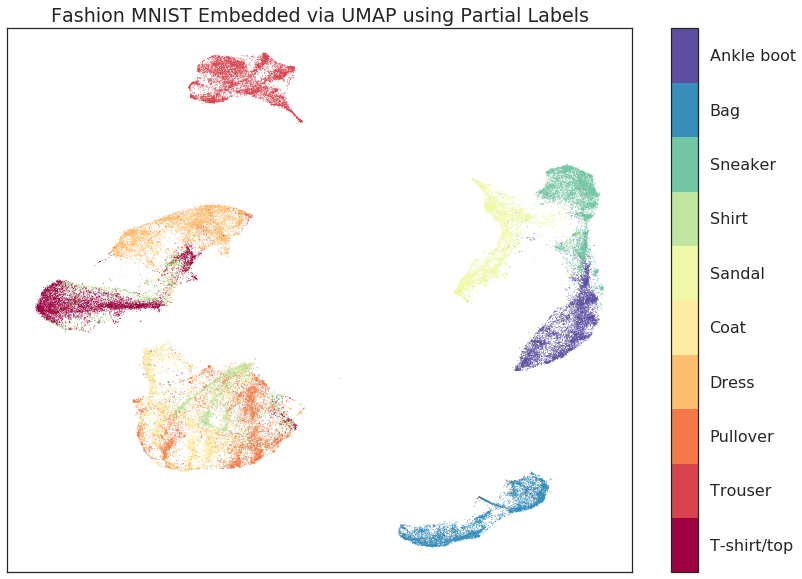

In [14]:
fig, ax = plt.subplots(1, figsize=(14, 10))
plt.scatter(*embedding.T, s=0.1, c=target, cmap='Spectral', alpha=1.0)
plt.setp(ax, xticks=[], yticks=[])
cbar = plt.colorbar(boundaries=np.arange(11)-0.5)
cbar.set_ticks(np.arange(10))
cbar.set_ticklabels(classes)
plt.title('Fashion MNIST Embedded via UMAP using Partial Labels');

The result is much as we would expect -- while we haven't cleanly separated the data as we did in the totally supervised case, the classes have been made cleaner and more distinct. This semi-supervised approach provides a powerful tool when labelling is potentially expensive, or when you have more data than labels, but want to make use of that extra data.

## Training with Labels and Embedding Unlabelled Test Data (Metric Learning with UMAP)

If we have learned a supervised embedding, can we use that to embed new previously unseen (and now unlabelled) points into the space? This would provide an algorithm for [metric learning](https://en.wikipedia.org/wiki/Similarity_learning#Metric_learning), where we can use a labelled set of points to learn a metric on data, and then use that learned metric as a measure of distance between new unlabelled points. This can be particularly useful as part of a machine learning pipline where we learn a supervised embedding as a form of supervised feature engineering, and then build a classifier on that new space -- this is viable as long as we can pass new data to the embedding model to be transformed to the new space.

To try this out with UMAP let's use the train/test split provided by Fashion MNIST:

In [15]:
train_data = np.array(train)
test_data = np.array(test)

Now we can fit a model to the training data, making use of the training labels to learn a supervised embedding.

In [33]:
%%time
mapper = umap.UMAP(n_neighbors=10).fit(train_data, np.array(train_labels))

/opt/anaconda3/envs/umap_dev/lib/python3.6/site-packages/umap_learn-0.3.0-py3.6.egg/umap/spectral.py:187: UserWarning: Embedding 3 connected components using meta-embedding (experimental)


CPU times: user 2min 18s, sys: 7.53 s, total: 2min 26s
Wall time: 1min 52s


Next we can use the ``transform`` method on that model to transform the test set into the learned space. This time we won't pass the label information and let the model attempt to place the data correctly.

In [34]:
%%time
test_embedding = mapper.transform(test_data)

CPU times: user 17.3 s, sys: 986 ms, total: 18.3 s
Wall time: 15.4 s


UMAP transforms are not as fast as some approaches, but as you can see this was still fairly efficient. The important question is how well we managed to embed the test data into the existing learned space. To start let's visualise the embedding of the training data so we can get a sense of where things *should* go. 

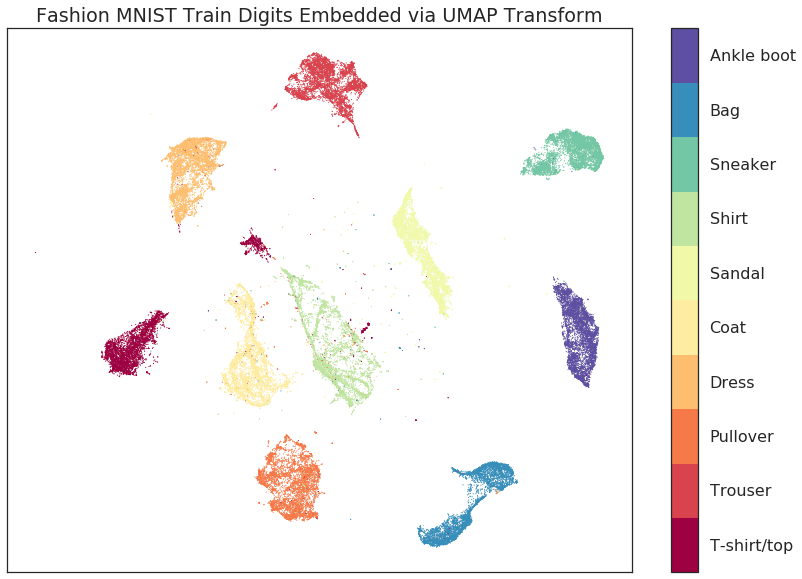

In [35]:
fig, ax = plt.subplots(1, figsize=(14, 10))
plt.scatter(*mapper.embedding_.T, s=0.3, c=np.array(train_labels), cmap='Spectral', alpha=1.0)
plt.setp(ax, xticks=[], yticks=[])
cbar = plt.colorbar(boundaries=np.arange(11)-0.5)
cbar.set_ticks(np.arange(10))
cbar.set_ticklabels(classes)
plt.title('Fashion MNIST Train Digits Embedded via UMAP Transform');

As you can see this has done a similar job as before, successfully embedding the separate classes while retaining both the internal structure and the overall global structure. We can now look at how the test set, for which we provided no label information, was embedded via the ``transform`` method.

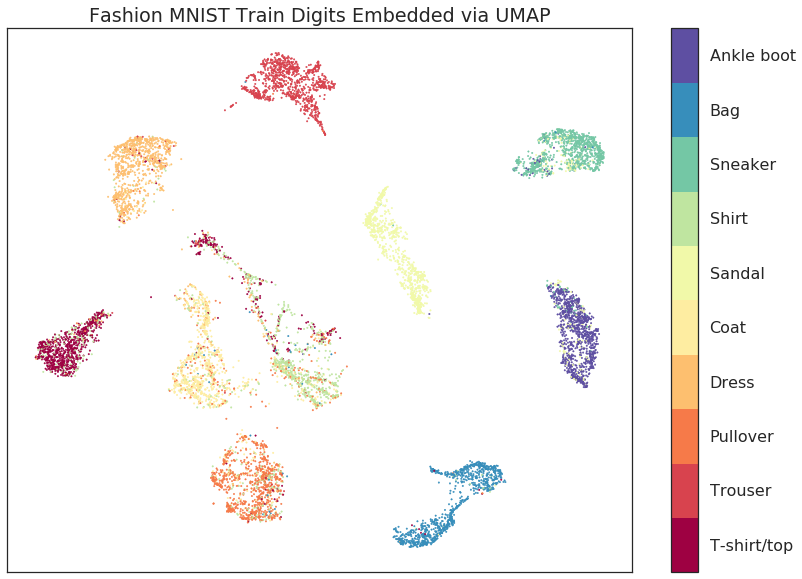

In [36]:
fig, ax = plt.subplots(1, figsize=(14, 10))
plt.scatter(*test_embedding.T, s=2, c=np.array(test_labels), cmap='Spectral', alpha=1.0)
plt.setp(ax, xticks=[], yticks=[])
cbar = plt.colorbar(boundaries=np.arange(11)-0.5)
cbar.set_ticks(np.arange(10))
cbar.set_ticklabels(classes)
plt.title('Fashion MNIST Train Digits Embedded via UMAP');

As you can see we have replicated the layout of the training data, including much of the internal structure of the classes. For the most part assignment of new points follows the classes well. The greatest source of confusion in some t-shirts that ended up in mixed with the shirts, and some pullovers which are confused with the coats. Given the difficulty of the problemn this is a good result, particularly when compared with current state-of-the-art approaches such as [siamese and triplet networks](https://github.com/adambielski/siamese-triplet/blob/master/Experiments_FashionMNIST.ipynb).